In [1]:
%load_ext autoreload
%autoreload 2

# CNN in TensorFlow

## Import module

In [2]:
# modules
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from textminer.embedding import Embeddor
from sklearn.model_selection import train_test_split
%matplotlib inline

Using TensorFlow backend.


## Loading movie reviews data

In [3]:
# loading x and y

src = "../../02_DATA/03_movie_review/rt-polaritydata/"
pos_src = src + "rt-polarity.pos"
neg_src = src + "rt-polarity.neg"

with open(pos_src) as f:
    pos_txt = f.readlines()
    y_pos = [1] * len(pos_txt)

with open(neg_src) as f:
    neg_txt = f.readlines()
    y_neg = [0] * len(neg_txt)
    
x_total = np.concatenate((pos_txt, neg_txt))
y_total = np.concatenate((y_pos, y_neg))
n = np.size(x_total)

print("There is %d elements in x" % n)

There is 10662 elements in x


## Loading embedding

In [4]:
%%time

# parameters
n_emb = 100000
src_emb = "../../01_WORD_EMBEDDING/fasttext.wiki.en.vec"

# embeddor
embeddor = Embeddor(notebook_display=True)
emb_mat = embeddor.load_emb(src_emb, n_emb)
print("Embedding shape: {}".format(emb_mat.shape))


Embedding shape: (100001, 300)
Wall time: 11.2 s


## Sampling data

In [5]:
# to take away

sampling = False

if sampling:
    n = np.size(x_total)
    n_samples = 3000
    print("Percentage of data used: %0.1f%%" % (100*n_samples/n))
    idx_samples = np.random.randint(0, n, size=n_samples)
    x = x_total[idx_samples]
    y = y_total[idx_samples]
else:
    x = x_total
    y = y_total
    print("Use all data")

Use all data


## CNN parameters

In [6]:
# input
emb_mat = embeddor.emb
emb_shape = np.shape(emb_mat)
emb_size = emb_shape[1]
x_seq = embeddor.to_seq(x, padding=True)
y_seq = y
seq_size = embeddor.pad_dim
filter_size = 6
num_filters = 100
num_classes = 2

## Defining graph structure

In [7]:
%%time

# placeholders
x_input = tf.placeholder(tf.int32, shape=[None, None], name='x_input')
y_input = tf.placeholder(tf.int64, shape=[None], name='y_input')
e_input = tf.placeholder(tf.float32, shape=emb_shape, name='e_input')
dropout = tf.placeholder(tf.float32, name="dropout_keep_prob")

with tf.device("/cpu:0"):
    
    # embedding initialization
    with tf.name_scope("embedding"):
        E = tf.Variable(tf.constant(0.0, shape=emb_shape), trainable=False, name="E")
        emb_init = E.assign(e_input)
        emb_seq = tf.nn.embedding_lookup(E, x_input)
        emb_seq_expanded = tf.expand_dims(emb_seq, -1)
    
    # convolution layer
    with tf.name_scope("convolution"):
        # convolution
        filter_shape = [filter_size, emb_size, 1, num_filters]
        W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name='W')
        b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name='b')
        conv = tf.nn.conv2d(emb_seq_expanded,
                            W, 
                            strides=[1, 1, 1, 1],
                            padding='VALID',
                            name='conv')
        # non-linearity
        h = tf.nn.tanh(tf.nn.bias_add(conv, b), name='tanh')
        # k-max
        h_pool = tf.nn.max_pool(h,
                                ksize=[1, seq_size - filter_size + 1, 1, 1],
                                strides=[1, 1, 1, 1],
                                padding='VALID',
                                name='pool')
        h_pool_flat = tf.reshape(h_pool, [-1, num_filters])
    
    # dropout
    with tf.name_scope("dropout"):
        h_o = tf.nn.dropout(h_pool_flat, dropout)
        
    # output
    with tf.name_scope("output"):
        W_o = tf.Variable(tf.truncated_normal([num_filters, num_classes], stddev=0.1), name='W_o')
        b_o = tf.Variable(tf.constant(0.1, shape=[num_classes]), name='b_o')
        scores = tf.nn.xw_plus_b(h_o, W_o, b_o, name='scores')
        preds = tf.argmax(scores, 1, name='preds')
        
    # calculate mean cross-entropy loss
    with tf.name_scope("loss"):
        losses = tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=scores,
            labels=y_input,
            name='losses')
        loss = tf.reduce_mean(losses, name='loss')

    # accuracy
    with tf.name_scope("accuracy"):
        correct_predictions = tf.equal(preds, y_input)
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, 'float'), name='accuracy')
    
    # optimization
    with tf.name_scope("optimization"):
        optimizer = tf.train.AdamOptimizer(1e-3)
        train_op = optimizer.minimize(loss)
        
    init = tf.global_variables_initializer()

Wall time: 203 ms


In [8]:
%%time
with tf.Session() as sess:
    sess.run(init)
    sess.run(emb_init, feed_dict={e_input: emb_mat})
    D = {x_input: x_seq, y_input: y_seq}
    out = sess.run(emb_seq, feed_dict=D)

Wall time: 978 ms


In [9]:
batch_size = 32
num_epochs = 10
p = 1
x_train, x_test, y_train, y_test = train_test_split(x_seq, y_seq, train_size=0.75, random_state=0)

In [10]:
%%time
with tf.Session() as sess:
    # initialization of all variables
    sess.run(init)
    sess.run(emb_init, feed_dict={e_input: emb_mat})
    
    # perform operation
    losses = []
    for e in range(num_epochs):
        for i in range(x_train.shape[0] // batch_size):
            # idx batches
            idx = i * batch_size
            idxn = min(x_train.shape[0] - 1, (i+1) * batch_size)
            # batches
            batch_xs = x_train[idx: idxn]
            batch_xy = y_train[idx: idxn]
            
            # run train operator
            feed_train ={x_input: batch_xs, y_input: batch_xy, dropout: p}
            _, l = sess.run([train_op, loss], feed_dict=feed_train)
            losses.append(l)

        # for each epoch, run accuracy on train and test
        acc_train = sess.run(accuracy, feed_dict={x_input: x_train, y_input: y_train, dropout: 1})
        acc_test = sess.run(accuracy, feed_dict={x_input: x_test, y_input: y_test, dropout: 1})
        print("epoch: %d train acc: %0.2f test acc: %0.2f" %  (e, acc_train, acc_test))
        
    # monitoring
    file_writer = tf.summary.FileWriter('./tensorflow_summaries', sess.graph)

epoch: 0 train acc: 0.78 test acc: 0.73
epoch: 1 train acc: 0.85 test acc: 0.76
epoch: 2 train acc: 0.91 test acc: 0.77
epoch: 3 train acc: 0.95 test acc: 0.77
epoch: 4 train acc: 0.98 test acc: 0.77
epoch: 5 train acc: 0.99 test acc: 0.77
epoch: 6 train acc: 1.00 test acc: 0.77
epoch: 7 train acc: 1.00 test acc: 0.76
epoch: 8 train acc: 1.00 test acc: 0.76
epoch: 9 train acc: 0.99 test acc: 0.75
Wall time: 4min 53s


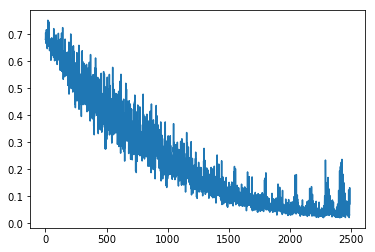

In [11]:
plt.plot(losses)

In [12]:
embeddor.most_similar("you")

[('you', 0.99999952),
 ('yourself', 0.81855571),
 ('your', 0.78942794),
 ('we', 0.77363455),
 ('want', 0.7607674),
 ('somebody', 0.75014383),
 ('know', 0.74101084),
 ('honestly', 0.72648555),
 ('myself', 0.72524768),
 ('#you', 0.72140479)]

# Retrieve every embedding possible

In [13]:
from tqdm import tqdm, tqdm_notebook
from textminer.embedding import get_sorted_voc

In [14]:
voc = get_sorted_voc(x)
print("vocabulary is composed of %d words" % len(voc))

vocabulary is composed of 18404 words


In [15]:
# get whole vocabulary
complete_list = list()
with open(src_emb, 'rb') as f:
    n_global, dim = map(int, f.readline().split())
    for idx in tqdm_notebook(range(n_global)):
        raw = f.readline().decode('utf-8').rstrip(' \n')
        line = raw.split(' ')
        word = line[0]
        complete_list.append(word)